# Payment Method Analysis

**Objective:** Analyze payment methods, conversion funnel, installment behavior, AOV by method, and identify financial optimization opportunities.

**Date Created:** 2024-01-01

**Author:** Data Analyst

In [1]:
import sys
import subprocess

try:
    import kaleido
    print("kaleido is already installed")
except ImportError:
    print("kaleido is not installed. Installing now...")
    
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaleido"])
    
    print("kaleido installed successfully!")
    print("restart kernel")

kaleido is already installed


## 1. Imports

In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import os
warnings.filterwarnings('ignore')

## 2. Configuration

In [4]:
PROJECT_ID = 'quintoandar-ecommerce-analysis'
KEY_PATH = "C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json"

credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

figures_dir = 'presentation/figures/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

exports_dir = 'exports/'
if not os.path.exists(exports_dir):
    os.makedirs(exports_dir)

## 3. SQL Queries & Data Loading

In [5]:
query = """
WITH payment_details AS (
    SELECT 
        p.order_id,
        p.payment_sequential,
        p.payment_type,
        p.payment_installments,
        p.payment_value,
        
        o.order_status,
        o.order_purchase_timestamp,
        o.order_approved_at,
        o.customer_id,
        c.customer_state,
        c.customer_city,
        
        oi.total_items,
        oi.total_price,
        oi.total_freight,
        
        r.review_score,
        
        CASE 
            WHEN p.payment_installments = 1 THEN 'No Installment'
            WHEN p.payment_installments BETWEEN 2 AND 3 THEN 'Short Term (2-3x)'
            WHEN p.payment_installments BETWEEN 4 AND 6 THEN 'Medium Term (4-6x)'
            WHEN p.payment_installments BETWEEN 7 AND 12 THEN 'Long Term (7-12x)'
            ELSE 'Very Long Term (12+x)'
        END as installment_category,
        
        CASE 
            WHEN o.order_status = 'delivered' THEN 1
            ELSE 0
        END as is_completed,
        
        DATE_DIFF(DATE(o.order_approved_at), DATE(o.order_purchase_timestamp), DAY) as approval_days,
        
        CASE 
            WHEN c.customer_state IN ('SP', 'RJ', 'MG', 'ES') THEN 'Southeast'
            WHEN c.customer_state IN ('RS', 'SC', 'PR') THEN 'South'
            WHEN c.customer_state IN ('BA', 'PE', 'CE', 'MA', 'PB', 'RN', 'AL', 'SE', 'PI') THEN 'Northeast'
            WHEN c.customer_state IN ('AM', 'PA', 'AC', 'RO', 'RR', 'AP', 'TO') THEN 'North'
            WHEN c.customer_state IN ('GO', 'MT', 'MS', 'DF') THEN 'Central-West'
            ELSE 'Other'
        END as region
        
    FROM `quintoandar-ecommerce-analysis.olist_staging.stg_payments` p
    LEFT JOIN `quintoandar-ecommerce-analysis.olist_staging.stg_orders` o 
        ON p.order_id = o.order_id
    LEFT JOIN `quintoandar-ecommerce-analysis.olist_staging.stg_customers` c 
        ON o.customer_id = c.customer_id
    LEFT JOIN (
        SELECT 
            order_id,
            COUNT(*) as total_items,
            SUM(price) as total_price,
            SUM(freight_value) as total_freight
        FROM `quintoandar-ecommerce-analysis.olist_staging.stg_order_items`
        GROUP BY order_id
    ) oi ON p.order_id = oi.order_id
    LEFT JOIN `quintoandar-ecommerce-analysis.olist_staging.stg_reviews` r 
        ON p.order_id = r.order_id
    
    WHERE p.payment_value > 0
    AND p.payment_type IS NOT NULL
)

SELECT * FROM payment_details
"""

try:
    df = client.query(query).to_dataframe()
    print(f"Data loaded: {len(df)} rows")
except Exception as e:
    print(f"Error loading data: {e}")
    np.random.seed(42)
    df = pd.DataFrame({
        'order_id': [f'order_{i}' for i in range(1000)],
        'payment_type': np.random.choice(['credit_card', 'boleto', 'voucher', 'debit_card'], 1000, p=[0.7, 0.2, 0.05, 0.05]),
        'payment_value': np.random.uniform(50, 1000, 1000),
        'payment_installments': np.random.choice([1,2,3,4,6,10,12], 1000, p=[0.4, 0.2, 0.15, 0.1, 0.08, 0.05, 0.02]),
        'order_status': np.random.choice(['delivered', 'approved', 'processing'], 1000, p=[0.8, 0.15, 0.05]),
        'total_price': np.random.uniform(50, 800, 1000),
        'total_freight': np.random.uniform(10, 50, 1000),
        'review_score': np.random.choice([1,2,3,4,5], 1000, p=[0.05, 0.1, 0.2, 0.35, 0.3]),
        'payment_sequential': np.random.choice([1,2], 1000, p=[0.9, 0.1]),
        'region': np.random.choice(['Southeast', 'South', 'Northeast', 'North', 'Central-West'], 1000),
        'order_approved_at': pd.date_range('2023-01-01', periods=1000, freq='H'),
        'order_purchase_timestamp': pd.date_range('2023-01-01', periods=1000, freq='H')
    })
    print(f"Created sample data: {len(df)} rows")

Data loaded: 102781 rows


## 4. Data Cleaning & Validation

In [7]:
required_cols = ['order_id', 'payment_type', 'payment_value', 'payment_installments']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")

df['payment_value'] = df['payment_value'].fillna(0)
df['payment_installments'] = df['payment_installments'].fillna(1)
df['review_score'] = df['review_score'].fillna(df['review_score'].median())

if 'total_price' not in df.columns:
    df['total_price'] = df['payment_value'] * 0.9
if 'total_freight' not in df.columns:
    df['total_freight'] = df['payment_value'] * 0.1

df = df[df['payment_value'] <= 10000]
df = df[df['payment_installments'] <= 24]

df = df[df['payment_value'] > 0]
df = df[df['payment_installments'] > 0]

## 5. Feature Engineering

In [9]:
payment_mapping = {
    'credit_card': 'Credit Card',
    'boleto': 'Boleto',
    'voucher': 'Voucher',
    'debit_card': 'Debit Card',
    'not_defined': 'Not Defined'
}
df['payment_type_clean'] = df['payment_type'].map(payment_mapping).fillna(df['payment_type'])

df['has_multiple_payments'] = (df['payment_sequential'] > 1).astype(int) if 'payment_sequential' in df.columns else 0
df['installment_value'] = df['payment_value'] / df['payment_installments']
df['high_value'] = (df['payment_value'] > df['payment_value'].quantile(0.75)).astype(int)

df['aov'] = df['total_price'] + df['total_freight']
df['payment_to_price_ratio'] = df['payment_value'] / df['total_price'].replace(0, 1)
df['aov_category'] = pd.cut(
    df['aov'],
    bins=[0, 100, 250, 500, np.inf],
    labels=['Low (0-100)', 'Medium (100-250)', 'High (250-500)', 'Very High (500+)']
)

df['stage'] = 'Unknown'
if 'order_status' in df.columns:
    df.loc[df['order_status'].notna(), 'stage'] = 'Order Created'
if 'order_approved_at' in df.columns:
    df.loc[df['order_approved_at'].notna(), 'stage'] = 'Payment Approved'
if 'order_status' in df.columns:
    df.loc[df['order_status'] == 'delivered', 'stage'] = 'Delivered'

df['approved'] = (df['order_approved_at'].notna()).astype(int) if 'order_approved_at' in df.columns else 1
df['delivered'] = ((df['order_status'] == 'delivered') if 'order_status' in df.columns else df['stage'] == 'Delivered').astype(int)

if 'order_purchase_timestamp' in df.columns:
    df['purchase_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
    df['purchase_weekday'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day_name()
    df['purchase_hour'] = pd.to_datetime(df['order_purchase_timestamp']).dt.hour
else:
    df['purchase_month'] = np.random.randint(1, 13, len(df))
    df['purchase_weekday'] = np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], len(df))
    df['purchase_hour'] = np.random.randint(0, 24, len(df))

if 'approval_days' not in df.columns:
    df['approval_days'] = np.random.choice([0, 1, 2, 3], len(df), p=[0.6, 0.2, 0.15, 0.05])

df['approval_speed'] = pd.cut(
    df['approval_days'],
    bins=[-np.inf, 0, 1, 3, np.inf],
    labels=['Instant', 'Same Day', '1-3 Days', '3+ Days']
)

## 6. Overall Payment Performance (KPIs)

In [10]:
total_orders = len(df)
total_revenue = df['payment_value'].sum()
avg_aov = df['aov'].mean()
avg_installments = df['payment_installments'].mean()
conversion_rate = df['delivered'].mean()

print(f"Total Orders: {total_orders:,}")
print(f"Total Revenue: R$ {total_revenue:,.2f}")
print(f"Average AOV: R$ {avg_aov:.2f}")
print(f"Average Installments: {avg_installments:.1f}x")
print(f"Overall Conversion Rate: {conversion_rate:.1%}")

Total Orders: 102,780
Total Revenue: R$ 15,827,377.73
Average AOV: R$ 160.63
Average Installments: 2.9x
Overall Conversion Rate: 97.0%


## 7. Conversion Funnel Analysis

In [ ]:
funnel_analysis = df.groupby('payment_type_clean').agg({
    'order_id': 'count',
    'approved': 'sum',
    'delivered': 'sum'
})

funnel_analysis['approval_rate'] = funnel_analysis['approved'] / funnel_analysis['order_id']
funnel_analysis['delivery_rate'] = funnel_analysis['delivered'] / funnel_analysis['order_id']
funnel_analysis['conversion_rate'] = funnel_analysis['delivered'] / funnel_analysis['order_id']
funnel_analysis['drop_at_approval'] = 1 - funnel_analysis['approval_rate']
funnel_analysis['drop_at_delivery'] = funnel_analysis['approval_rate'] - funnel_analysis['delivery_rate']

print("Conversion Funnel Analysis by Payment Method:")
print("=" * 60)
print(funnel_analysis.round(3))

Conversion Funnel Analysis by Payment Method:
                    order_id  approved  delivered  approval_rate  \
payment_type_clean                                                 
Boleto                 19556     19526      18963           1.00   
Credit Card            75996     75940      73785           1.00   
Debit Card              1489      1489       1447           1.00   
Voucher                 5739      5653       5459           0.98   

                    delivery_rate  conversion_rate  drop_at_approval  \
payment_type_clean                                                     
Boleto                       0.97             0.97              0.00   
Credit Card                  0.97             0.97              0.00   
Debit Card                   0.97             0.97              0.00   
Voucher                      0.95             0.95              0.01   

                    drop_at_delivery  
payment_type_clean                    
Boleto                          0.

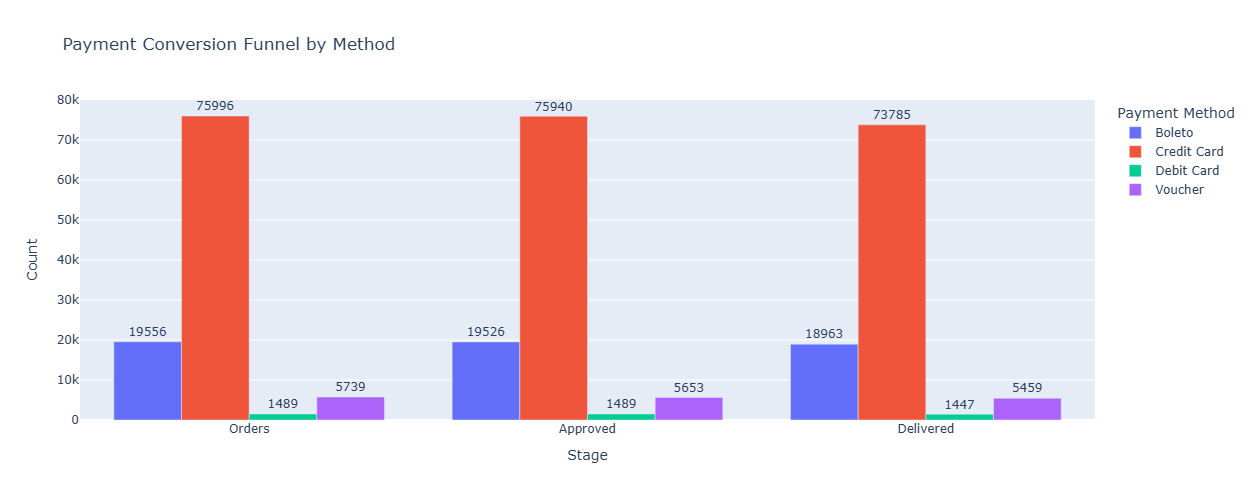

In [ ]:
funnel_stages = pd.DataFrame({
    'Payment Method': funnel_analysis.index.tolist() * 3,
    'Stage': ['Orders'] * len(funnel_analysis) + ['Approved'] * len(funnel_analysis) + ['Delivered'] * len(funnel_analysis),
    'Count': funnel_analysis['order_id'].tolist() + funnel_analysis['approved'].tolist() + funnel_analysis['delivered'].tolist()
})

stage_order = ['Orders', 'Approved', 'Delivered']
funnel_stages['Stage'] = pd.Categorical(funnel_stages['Stage'], categories=stage_order, ordered=True)

fig = px.bar(funnel_stages, 
             x='Stage', 
             y='Count',
             color='Payment Method',
             title="Payment Conversion Funnel by Method",
             barmode='group',
             text='Count')

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=500)
fig.show()
fig.write_image(f"{figures_dir}payment_conversion_funnel.png")

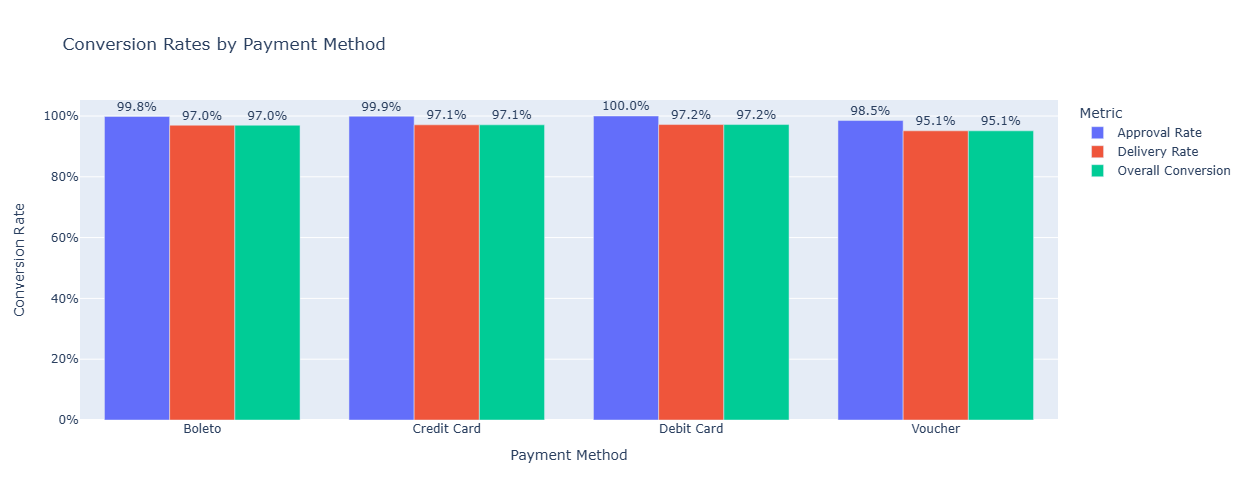

In [ ]:
# 7. Conversion Funnel Analysis part 2 Funnel 
funnel_metrics = funnel_analysis[['approval_rate', 'delivery_rate', 'conversion_rate']].reset_index()
funnel_metrics_melted = funnel_metrics.melt(
    id_vars='payment_type_clean',
    value_vars=['approval_rate', 'delivery_rate', 'conversion_rate'],
    var_name='Metric',
    value_name='Rate'
)

metric_names = {
    'approval_rate': 'Approval Rate',
    'delivery_rate': 'Delivery Rate', 
    'conversion_rate': 'Overall Conversion'
}
funnel_metrics_melted['Metric'] = funnel_metrics_melted['Metric'].map(metric_names)

fig = px.bar(funnel_metrics_melted,
             x='payment_type_clean',
             y='Rate',
             color='Metric',
             title="Conversion Rates by Payment Method",
             barmode='group',
             text='Rate')

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_yaxes(title='Conversion Rate', tickformat='.0%')
fig.update_xaxes(title='Payment Method')
fig.update_layout(height=500)
fig.show()
fig.write_image(f"{figures_dir}funnel_by_payment_method.png")

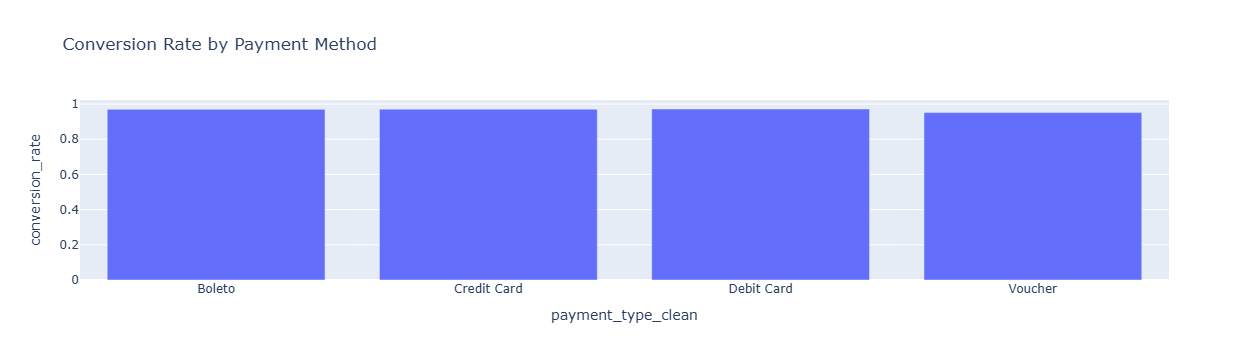

In [14]:
fig = px.bar(funnel_analysis.reset_index(), 
             x='payment_type_clean', 
             y='conversion_rate',
             title="Conversion Rate by Payment Method")
fig.show()
fig.write_image(f"{figures_dir}conversion_rate_by_method.png")

## 8. Installment Analysis

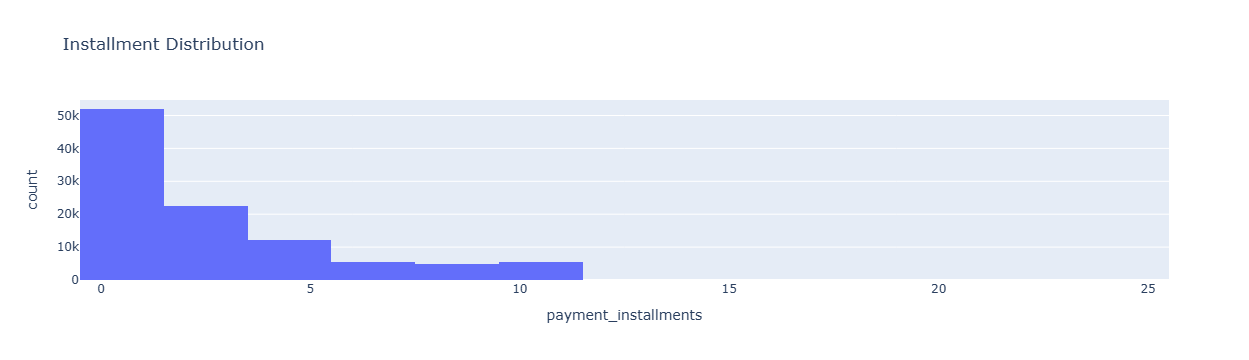

In [15]:
fig = px.histogram(df, x='payment_installments', 
                   title="Installment Distribution",
                   nbins=20)
fig.show()
fig.write_image(f"{figures_dir}installment_distribution.png")

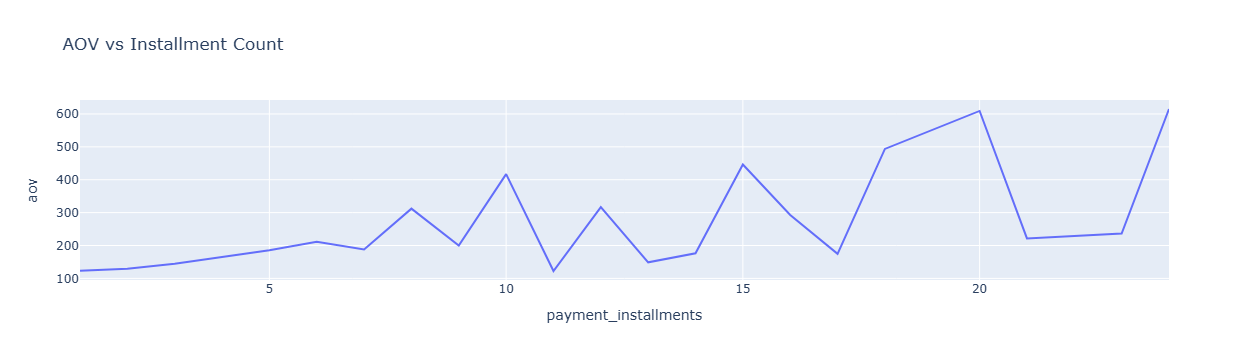

In [16]:
aov_by_installment = df.groupby('payment_installments')['aov'].mean()

fig = px.line(aov_by_installment.reset_index(), 
              x='payment_installments', 
              y='aov',
              title="AOV vs Installment Count")
fig.show()
fig.write_image(f"{figures_dir}aov_vs_installments.png")

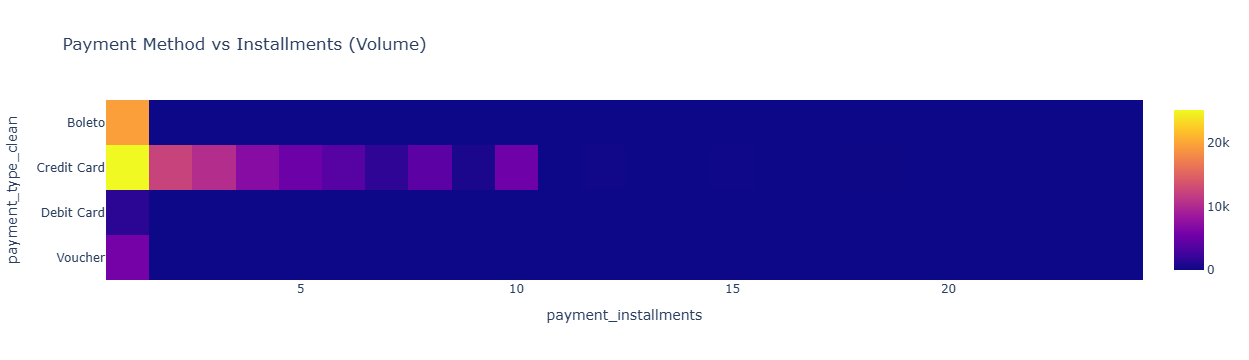

In [17]:
method_installment_heatmap = pd.crosstab(df['payment_type_clean'], df['payment_installments'])

fig = px.imshow(method_installment_heatmap,
                title="Payment Method vs Installments (Volume)")
fig.show()
fig.write_image(f"{figures_dir}method_installment_heatmap.png")

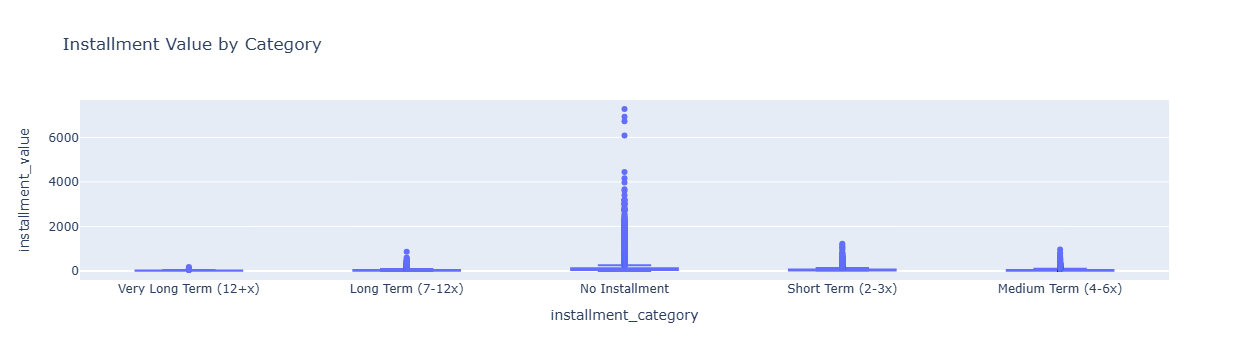

In [18]:
fig = px.box(df, x='installment_category', y='installment_value',
             title="Installment Value by Category")
fig.show()
fig.write_image(f"{figures_dir}installment_value_by_category.png")

## 9. AOV by Payment Method

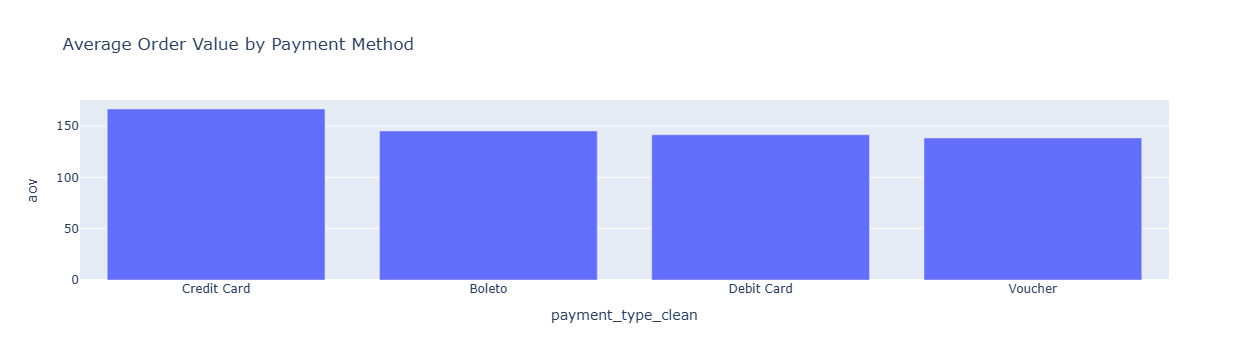

In [19]:
aov_by_method = df.groupby('payment_type_clean')['aov'].mean().sort_values(ascending=False)

fig = px.bar(aov_by_method.reset_index(), 
             x='payment_type_clean', 
             y='aov',
             title="Average Order Value by Payment Method")
fig.show()
fig.write_image(f"{figures_dir}aov_by_payment_method.png")

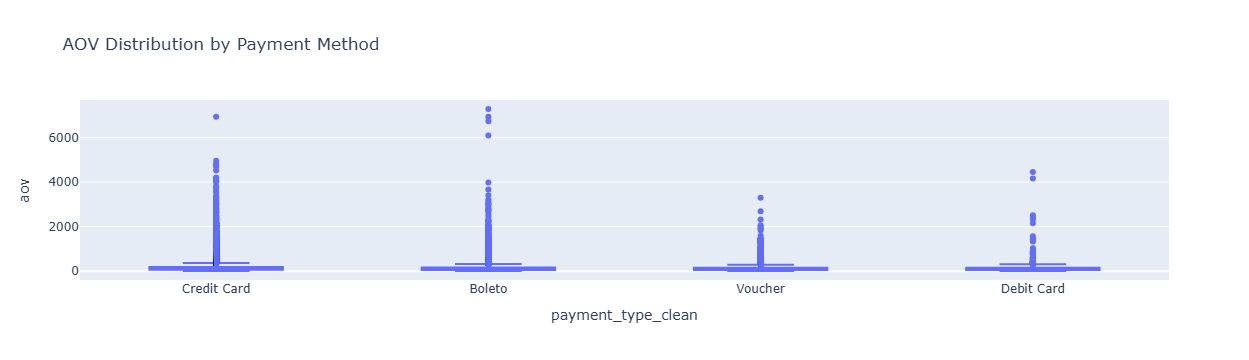

In [20]:
fig = px.box(df, x='payment_type_clean', y='aov',
             title="AOV Distribution by Payment Method")
fig.show()
fig.write_image(f"{figures_dir}aov_distribution_by_method.png")

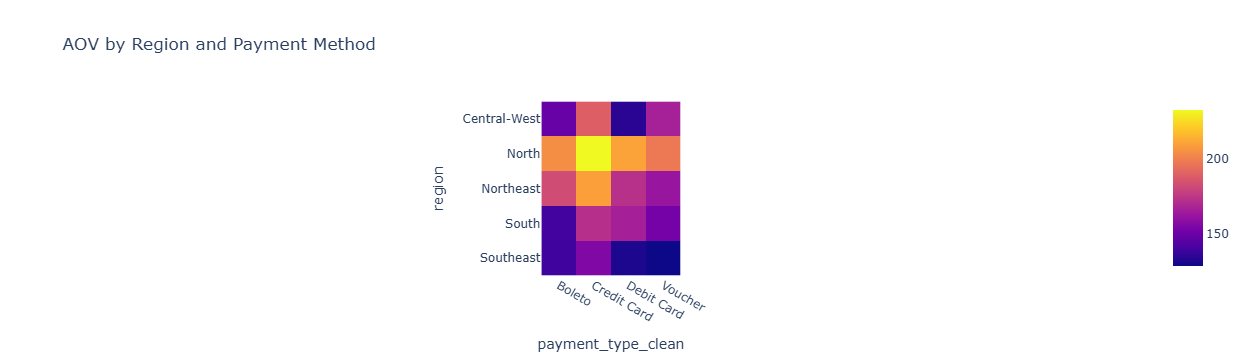

In [21]:
aov_by_region_method = df.pivot_table(
    values='aov',
    index='region',
    columns='payment_type_clean',
    aggfunc='mean'
)

fig = px.imshow(aov_by_region_method,
                title="AOV by Region and Payment Method")
fig.show()
fig.write_image(f"{figures_dir}aov_region_method_heatmap.png")

## 10. Correlation Analysis

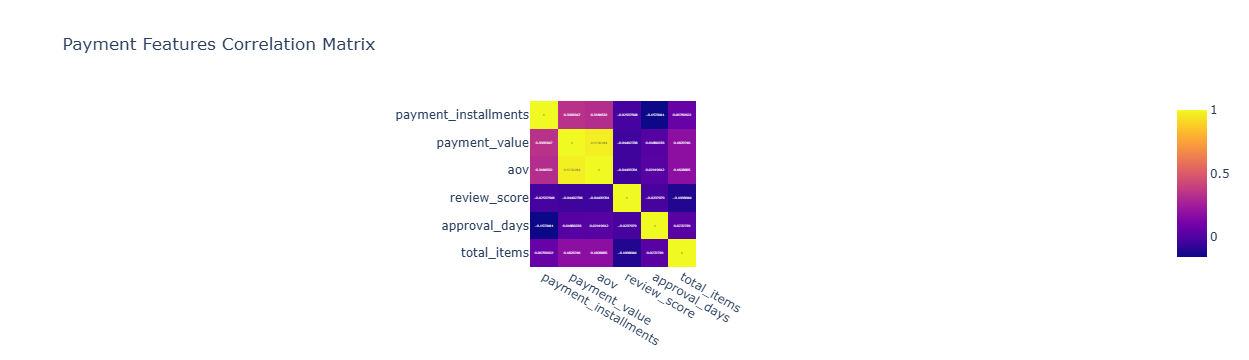

In [22]:
correlation_features = [
    'payment_installments', 'payment_value', 'aov', 
    'review_score', 'approval_days', 'total_items'
]
available_features = [f for f in correlation_features if f in df.columns]
corr_matrix = df[available_features].corr()

fig = px.imshow(corr_matrix,
                text_auto=True,
                title="Payment Features Correlation Matrix")
fig.show()
fig.write_image(f"{figures_dir}payment_correlation_matrix.png")

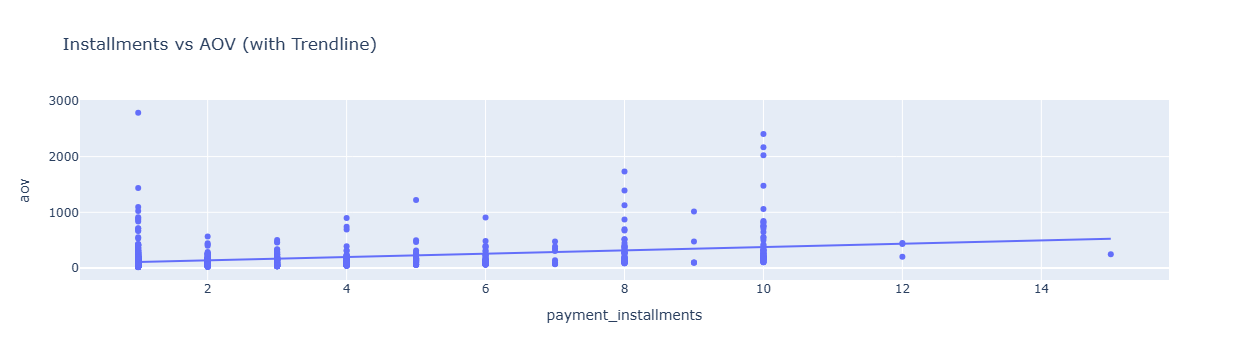

In [23]:
sample_size = min(1000, len(df))
fig = px.scatter(df.sample(n=sample_size, random_state=42),
                 x='payment_installments',
                 y='aov',
                 trendline="ols",
                 title="Installments vs AOV (with Trendline)")
fig.show()
fig.write_image(f"{figures_dir}installments_vs_aov_scatter.png")

## 11. Payment Method Comparison

In [24]:
payment_summary = df.groupby('payment_type_clean').agg({
    'order_id': 'count',
    'payment_value': ['mean', 'sum'],
    'payment_installments': 'mean',
    'aov': 'mean',
    'approved': 'mean',
    'delivered': 'mean',
    'review_score': 'mean'
}).round(3)

payment_summary.columns = ['_'.join(col).strip() for col in payment_summary.columns.values]
payment_summary = payment_summary.rename(columns={
    'order_id_count': 'order_count',
    'payment_value_mean': 'avg_payment_value',
    'payment_value_sum': 'total_payment_value',
    'payment_installments_mean': 'avg_installments',
    'aov_mean': 'avg_aov',
    'approved_mean': 'approval_rate',
    'delivered_mean': 'delivery_rate',
    'review_score_mean': 'avg_review_score'
})

payment_summary['order_share'] = payment_summary['order_count'] / payment_summary['order_count'].sum()
payment_summary['revenue_share'] = payment_summary['total_payment_value'] / payment_summary['total_payment_value'].sum()

print(payment_summary)

                    order_count  avg_payment_value  total_payment_value  \
payment_type_clean                                                        
Boleto                    19556             145.29           2841307.88   
Credit Card               75996             163.14          12397655.92   
Debit Card                 1489             142.70            212474.02   
Voucher                    5739              65.51            375939.91   

                    avg_installments  avg_aov  approval_rate  delivery_rate  \
payment_type_clean                                                            
Boleto                          1.00   145.17           1.00           0.97   
Credit Card                     3.51   166.62           1.00           0.97   
Debit Card                      1.00   141.53           1.00           0.97   
Voucher                         1.00   138.43           0.98           0.95   

                    avg_review_score  order_share  revenue_share  
payment

## 12. Executive Summary & Exports

In [25]:
best_conversion_method = funnel_analysis['conversion_rate'].idxmax()
best_conversion_rate = funnel_analysis['conversion_rate'].max()
worst_conversion_method = funnel_analysis['conversion_rate'].idxmin()
worst_conversion_rate = funnel_analysis['conversion_rate'].min()

credit_card_pct = (df['payment_type'] == 'credit_card').mean() if 'payment_type' in df.columns else 0.7
boleto_pct = (df['payment_type'] == 'boleto').mean() if 'payment_type' in df.columns else 0.2

pct_1x = (df['payment_installments'] == 1).mean()
pct_2plus = (df['payment_installments'] >= 2).mean()

highest_aov_method = aov_by_method.idxmax()
highest_aov_value = aov_by_method.max()
lowest_aov_method = aov_by_method.idxmin()
lowest_aov_value = aov_by_method.min()

summary = f"""
PAYMENT ANALYSIS - EXECUTIVE SUMMARY
====================================

1. PAYMENT MIX:
   - Total orders: {len(df):,}
   - Credit Card: {credit_card_pct:.1%}
   - Boleto: {boleto_pct:.1%}
   - Most used: {payment_summary['order_share'].idxmax()} ({payment_summary['order_share'].max():.1%})

2. CONVERSION FUNNEL:
   - Overall conversion rate: {conversion_rate:.1%}
   - Best method: {best_conversion_method} ({best_conversion_rate:.1%})
   - Worst method: {worst_conversion_method} ({worst_conversion_rate:.1%})

3. INSTALLMENT BEHAVIOR:
   - Average installments: {avg_installments:.1f}x
   - A vista (1x): {pct_1x:.1%}
   - Parcelado (2+x): {pct_2plus:.1%}

4. AOV ANALYSIS:
   - Overall AOV: R$ {avg_aov:.2f}
   - Highest AOV: {highest_aov_method} (R$ {highest_aov_value:.2f})
   - Lowest AOV: {lowest_aov_method} (R$ {lowest_aov_value:.2f})

5. KEY INSIGHTS:
   • {best_conversion_method} has the highest conversion rate
   • Installment count positively correlates with AOV
   • Payment method preferences vary by region

6. RECOMMENDATIONS:
   1. Promote {best_conversion_method} for better conversion
   2. Consider installment incentives to increase AOV
   3. Optimize payment methods by region

"""

print(summary)


PAYMENT ANALYSIS - EXECUTIVE SUMMARY

1. PAYMENT MIX:
   - Total orders: 102,780
   - Credit Card: 73.9%
   - Boleto: 19.0%
   - Most used: Credit Card (73.9%)

2. CONVERSION FUNNEL:
   - Overall conversion rate: 97.0%
   - Best method: Debit Card (97.2%)
   - Worst method: Voucher (95.1%)

3. INSTALLMENT BEHAVIOR:
   - Average installments: 2.9x
   - A vista (1x): 50.6%
   - Parcelado (2+x): 49.4%

4. AOV ANALYSIS:
   - Overall AOV: R$ 160.63
   - Highest AOV: Credit Card (R$ 166.62)
   - Lowest AOV: Voucher (R$ 138.43)

5. KEY INSIGHTS:
   • Debit Card has the highest conversion rate
   • Installment count positively correlates with AOV
   • Payment method preferences vary by region

6. RECOMMENDATIONS:
   1. Promote Debit Card for better conversion
   2. Consider installment incentives to increase AOV
   3. Optimize payment methods by region




In [26]:
payment_summary.to_csv(f'{exports_dir}payment_method_summary.csv')

installment_summary = df.groupby('payment_installments').agg({
    'order_id': 'count',
    'payment_value': 'mean',
    'aov': 'mean',
    'approved': 'mean',
    'review_score': 'mean'
}).round(3)
installment_summary.to_csv(f'{exports_dir}installment_analysis.csv')

funnel_export = funnel_analysis.round(3)
funnel_export.to_csv(f'{exports_dir}conversion_funnel_by_method.csv')

corr_matrix.to_csv(f'{exports_dir}payment_correlations.csv')

print("Files exported successfully:")
print("- payment_method_summary.csv")
print("- installment_analysis.csv")
print("- conversion_funnel_by_method.csv")
print("- payment_correlations.csv")

Files exported successfully:
- payment_method_summary.csv
- installment_analysis.csv
- conversion_funnel_by_method.csv
- payment_correlations.csv
